In [ ]:
!pip install boto3
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.7 MB/s eta 0:00:00


In [ ]:
import boto3
import pandas as pd
from io import StringIO
import time
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import os

# Set AWS credentials using environment variables


In [ ]:
# Set up the S3 client
s3_client = boto3.client('s3')

# Define the bucket name and file key
bucket_name = 'beamdata-pocketride'
file_key = 'Toronto/Toronto Bikeshare May2023 - Apr2024.csv'

# Step 1: Start the timer
start_time = time.time()

# Step 2: Read the CSV file from S3
response = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Check if the file was fetched successfully
if response.get("ResponseMetadata", {}).get("HTTPStatusCode") == 200:
    # Load the CSV content into a pandas DataFrame
    df = pd.read_csv(StringIO(response['Body'].read().decode('utf-8')))

    # Step 3: Stop the timer
    end_time = time.time()

    # Calculate the total time taken
    time_taken = end_time - start_time

    # Display the DataFrame and the time taken
    df.head()
    print(f"\nTime taken to read the file from S3: {time_taken:.2f} seconds")
else:
    print("Failed to fetch the file from S3.")


Time taken to read the file from S3: 165.41 seconds


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5336042 entries, 0 to 5336041
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Start Time           object 
 1   Start Station Name   object 
 2   End Station Id       float64
 3   End Time             object 
 4   End Station Name     object 
 5   Bike Id              int64  
 6   User Type            object 
 7   lat_start            float64
 8   lon_start            float64
 9   lat_end              float64
 10  lon_end              float64
 11  Model                object 
 12  Trip Duration (min)  float64
 13  Hour                 int64  
 14  Day of Week          object 
 15  Month                object 
 16  Date                 object 
 17  Distance (km)        float64
 18  Speed (km/h)         float64
 19  Station Pair         object 
 20  Temperature          float64
 21  Dew Point            float64
 22  Relative Humidity    float64
 23  Precipitation        float64
 24

# Functions for z-score and IQR

In [ ]:
def analyze_column(df, column_name, z_threshold=3, iqr_factor=1.5):
    # Drop null values
    column_data = df[column_name].dropna()

    # Calculate original skewness
    original_skewness = column_data.skew()

    # Apply log transformation
    column_data_log = np.log1p(column_data)  # log1p is used to handle zero values

    # Calculate log skewness
    log_skewness = column_data_log.skew()

    # Calculate z-scores for log-transformed column
    z_scores_log = stats.zscore(column_data_log)

    # Calculate IQR for log-transformed column
    Q1 = column_data_log.quantile(0.25)
    Q3 = column_data_log.quantile(0.75)
    IQR = Q3 - Q1

    # Determine bounds for outliers
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR

    # Flag Z-score and IQR outliers
    z_outliers = np.abs(z_scores_log) > z_threshold
    iqr_outliers = (column_data_log < lower_bound) | (column_data_log > upper_bound)

    # Calculate confidence scores
    z_confidence = np.clip(np.abs(z_scores_log) / z_threshold, 0, 1)
    iqr_confidence = np.clip(
        np.where(column_data_log < lower_bound, (lower_bound - column_data_log) / IQR,
                 np.where(column_data_log > upper_bound, (column_data_log - upper_bound) / IQR, 0)),
        0, 1
    )

    # Combined confidence score
    combined_confidence = (z_confidence + iqr_confidence) / 2

    # Add new columns to the DataFrame
    df[f'IQR_{column_name}'] = iqr_outliers
    df[f'Z_OUTLIER_{column_name}'] = z_outliers
    df[f'CONFIDENCE_{column_name}'] = combined_confidence
    df[f'Z_LOG_SCORE_{column_name}'] = z_scores_log

    return original_skewness, log_skewness

def plot_histograms(df, column_name, original_skewness, log_skewness):
    column_data = df[column_name].dropna()
    column_data_log = np.log1p(column_data)

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(column_data, bins=50, color='blue', alpha=0.7)
    plt.title(f'Original {column_name} Histogram')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(column_data_log, bins=50, color='green', alpha=0.7)
    plt.title(f'Log-transformed {column_name} Histogram')
    plt.xlabel(f'Log({column_name})')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    print(f"Original Skewness of {column_name}: {original_skewness}")
    print(f"Log-transformed Skewness of {column_name}: {log_skewness}")



In [ ]:
# Drop rows where both 'Distance (km)' and 'Trip Duration (min)' are null
df_cleaned = df.dropna(subset=['Distance (km)', 'Trip Duration (min)'], how='all')

# Distance (km)

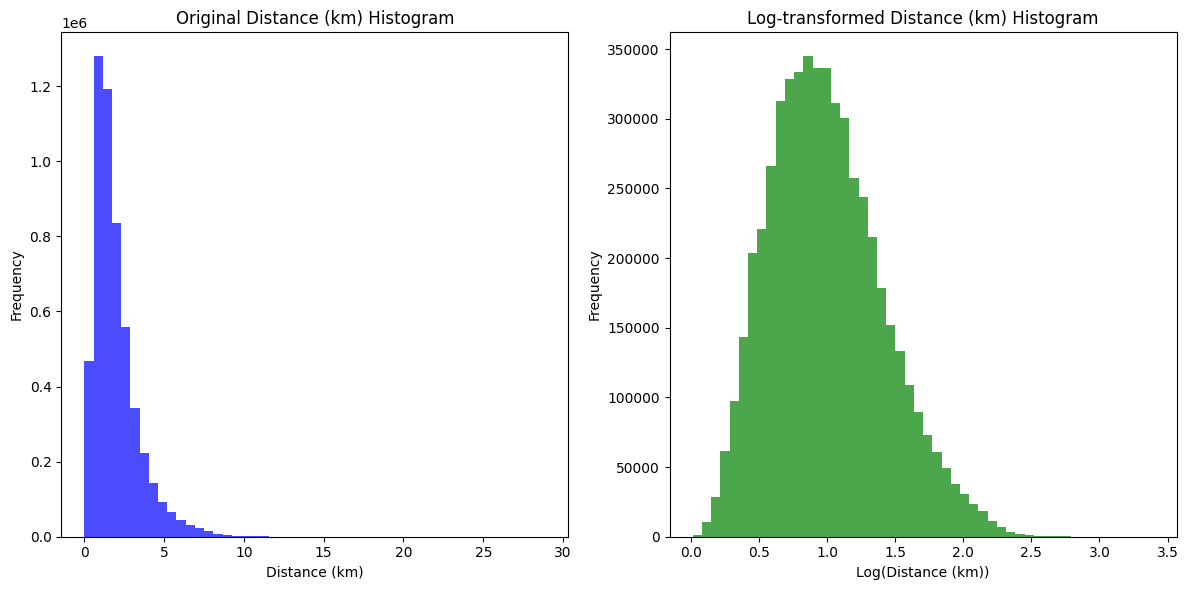

Original Skewness of Distance (km): 1.8469408509020604
Log-transformed Skewness of Distance (km): 0.49275210740273556


In [ ]:
# Example usage
# original_skewness, log_skewness = analyze_column(df, 'trip_miles')
# plot_histograms(df, 'trip_miles', original_skewness, log_skewness)
original_skewness, log_skewness = analyze_column(df_cleaned, 'Distance (km)')
plot_histograms(df_cleaned, 'Distance (km)', original_skewness, log_skewness)

# Trip Duration (min)

In [ ]:
# df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
# df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

In [ ]:
# # Extract day of the week, day of the month, hour, and minute for trip_start_timestamp
# df['start_day_of_week'] = df['trip_start_timestamp'].dt.dayofweek
# df['start_day_of_month'] = df['trip_start_timestamp'].dt.day
# df['start_hour'] = df['trip_start_timestamp'].dt.hour
# df['start_minute'] = df['trip_start_timestamp'].dt.minute

# # Extract day of the week, day of the month, hour, and minute for trip_end_timestamp
# df['end_day_of_week'] = df['trip_end_timestamp'].dt.dayofweek
# df['end_day_of_month'] = df['trip_end_timestamp'].dt.day
# df['end_hour'] = df['trip_end_timestamp'].dt.hour
# df['end_minute'] = df['trip_end_timestamp'].dt.minute

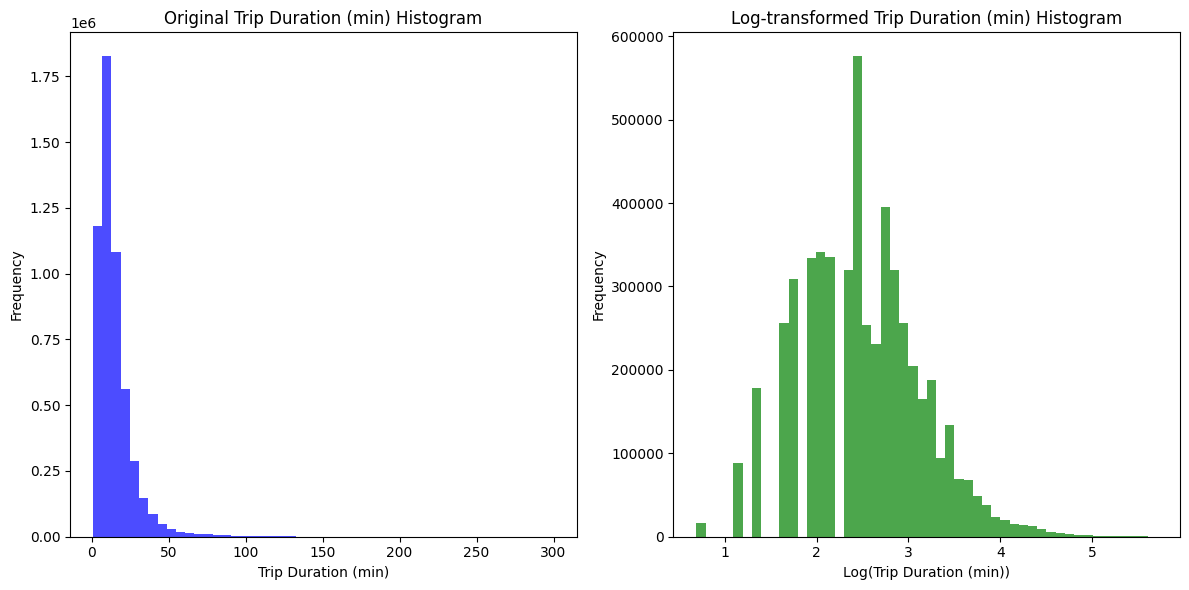

Original Skewness of Trip Duration (min): 4.79297012073435
Log-transformed Skewness of Trip Duration (min): 0.2593852058550293


In [ ]:
# Example usage
original_skewness, log_skewness = analyze_column(df_cleaned, 'Trip Duration (min)')
plot_histograms(df, 'Trip Duration (min)', original_skewness, log_skewness)

In [ ]:
df_cleaned.columns

Index(['Start Time', 'Start Station Name', 'End Station Id', 'End Time',
       'End Station Name', 'Bike Id', 'User Type', 'lat_start', 'lon_start',
       'lat_end', 'lon_end', 'Model', 'Trip Duration (min)', 'Hour',
       'Day of Week', 'Month', 'Date', 'Distance (km)', 'Speed (km/h)',
       'Station Pair', 'Temperature', 'Dew Point', 'Relative Humidity',
       'Precipitation', 'Wind Direction', 'Wind Speed', 'Pressure',
       'Cloud Cover', 'IQR_Distance (km)', 'Z_OUTLIER_Distance (km)',
       'CONFIDENCE_Distance (km)', 'Z_LOG_SCORE_Distance (km)',
       'IQR_Trip Duration (min)', 'Z_OUTLIER_Trip Duration (min)',
       'CONFIDENCE_Trip Duration (min)', 'Z_LOG_SCORE_Trip Duration (min)'],
      dtype='object')

In [ ]:
df_cleaned[['IQR_Distance (km)', 'Z_OUTLIER_Distance (km)',
       'CONFIDENCE_Distance (km)', 'Z_LOG_SCORE_Distance (km)',
       'IQR_Trip Duration (min)', 'Z_OUTLIER_Trip Duration (min)',
       'CONFIDENCE_Trip Duration (min)', 'Z_LOG_SCORE_Trip Duration (min)']].head()

,IQR_Distance (km),Z_OUTLIER_Distance (km),CONFIDENCE_Distance (km),Z_LOG_SCORE_Distance (km),IQR_Trip Duration (min),Z_OUTLIER_Trip Duration (min),CONFIDENCE_Trip Duration (min),Z_LOG_SCORE_Trip Duration (min)
0,False,False,0.144780,-0.868682,False,False,0.146380,-0.878282
1,False,False,0.052276,-0.313653,False,False,0.055076,-0.330456
2,False,False,0.240623,1.443735,False,False,0.122361,0.734168
3,False,False,0.240623,1.443735,False,False,0.122361,0.734168
4,False,False,0.053569,0.321413,False,False,0.012086,0.072517


In [ ]:
df_cleaned[['Distance (km)', 'IQR_Distance (km)', 'Z_OUTLIER_Distance (km)',
       'CONFIDENCE_Distance (km)', 'Z_LOG_SCORE_Distance (km)']].head()

,Distance (km),IQR_Distance (km),Z_OUTLIER_Distance (km),CONFIDENCE_Distance (km),Z_LOG_SCORE_Distance (km)
0,0.886951,False,False,0.144780,-0.868682
1,1.375765,False,False,0.052276,-0.313653
2,3.926852,False,False,0.240623,1.443735
3,3.926852,False,False,0.240623,1.443735
4,2.092239,False,False,0.053569,0.321413


In [ ]:
trip_distance_metrics = df_cleaned[['Distance (km)', 'IQR_Distance (km)', 'Z_OUTLIER_Distance (km)',
       'CONFIDENCE_Distance (km)', 'Z_LOG_SCORE_Distance (km)']]

In [ ]:
trip_distance_metrics.head()

,Distance (km),IQR_Distance (km),Z_OUTLIER_Distance (km),CONFIDENCE_Distance (km),Z_LOG_SCORE_Distance (km)
0,0.886951,False,False,0.144780,-0.868682
1,1.375765,False,False,0.052276,-0.313653
2,3.926852,False,False,0.240623,1.443735
3,3.926852,False,False,0.240623,1.443735
4,2.092239,False,False,0.053569,0.321413


In [ ]:
trip_distance_metrics.shape

(5336042, 5)

In [ ]:
trip_distance_metrics[trip_distance_metrics['CONFIDENCE_Distance (km)'] < 0.5]

,Distance (km),IQR_Distance (km),Z_OUTLIER_Distance (km),CONFIDENCE_Distance (km),Z_LOG_SCORE_Distance (km)
0,0.886951,False,False,0.144780,-0.868682
1,1.375765,False,False,0.052276,-0.313653
2,3.926852,False,False,0.240623,1.443735
3,3.926852,False,False,0.240623,1.443735
4,2.092239,False,False,0.053569,0.321413
...,...,...,...,...,...
5336037,2.629882,False,False,0.117943,0.707655
5336038,1.871015,False,False,0.023760,0.142562
5336039,5.154201,False,False,0.329946,1.979675
5336040,1.545785,False,False,0.024519,-0.147115


In [ ]:
# Extract entries where either 'IQR_Distance (km)' or 'Z_OUTLIER_Distance (km)' is True
filtered_trip_distance_metrics = trip_distance_metrics[
    (trip_distance_metrics['IQR_Distance (km)'] == True) |
    (trip_distance_metrics['Z_OUTLIER_Distance (km)'] == True)
]

In [ ]:
filtered_trip_distance_metrics

,Distance (km),IQR_Distance (km),Z_OUTLIER_Distance (km),CONFIDENCE_Distance (km),Z_LOG_SCORE_Distance (km)
196,8.215358,True,False,0.583021,2.952448
227,7.738688,True,False,0.515250,2.824481
457,7.381925,True,False,0.462063,2.724050
848,7.660982,True,False,0.503853,2.802960
876,7.450268,True,False,0.472425,2.743615
...,...,...,...,...,...
5335606,11.981188,True,True,0.890554,3.777989
5335613,11.981188,True,True,0.890554,3.777989
5335792,7.710351,True,False,0.511106,2.816655
5335831,9.169023,True,True,0.677056,3.189716


In [ ]:
trip_duration_metrics = df_cleaned[['Trip Duration (min)', 'IQR_Trip Duration (min)', 'Z_OUTLIER_Trip Duration (min)',
       'CONFIDENCE_Trip Duration (min)', 'Z_LOG_SCORE_Trip Duration (min)']]

In [ ]:
trip_duration_metrics.head()

,Trip Duration (min),IQR_Trip Duration (min),Z_OUTLIER_Trip Duration (min),CONFIDENCE_Trip Duration (min),Z_LOG_SCORE_Trip Duration (min)
0,6.0,False,False,0.146380,-0.878282
1,9.0,False,False,0.055076,-0.330456
2,19.0,False,False,0.122361,0.734168
3,19.0,False,False,0.122361,0.734168
4,12.0,False,False,0.012086,0.072517


In [ ]:
trip_duration_metrics.shape

(5336042, 5)

In [ ]:
trip_duration_metrics[trip_duration_metrics['CONFIDENCE_Trip Duration (min)'] < 0.5]

,Trip Duration (min),IQR_Trip Duration (min),Z_OUTLIER_Trip Duration (min),CONFIDENCE_Trip Duration (min),Z_LOG_SCORE_Trip Duration (min)
0,6.0,False,False,0.146380,-0.878282
1,9.0,False,False,0.055076,-0.330456
2,19.0,False,False,0.122361,0.734168
3,19.0,False,False,0.122361,0.734168
4,12.0,False,False,0.012086,0.072517
...,...,...,...,...,...
5336037,18.0,False,False,0.109231,0.655385
5336038,13.0,False,False,0.031057,0.186341
5336039,31.0,False,False,0.242676,1.456059
5336040,23.0,False,False,0.169033,1.014200


In [ ]:
# Extract entries where either 'IQR_Distance (km)' or 'Z_OUTLIER_Distance (km)' is True
filtered_trip_duration_metrics = trip_duration_metrics[
    (trip_duration_metrics['IQR_Trip Duration (min)'] == True) |
    (trip_duration_metrics['Z_OUTLIER_Trip Duration (min)'] == True)
]

In [ ]:
filtered_trip_duration_metrics

,Trip Duration (min),IQR_Trip Duration (min),Z_OUTLIER_Trip Duration (min),CONFIDENCE_Trip Duration (min),Z_LOG_SCORE_Trip Duration (min)
8,73.0,True,False,0.493192,2.743671
32,1.0,True,False,0.518401,-2.802434
85,82.0,True,False,0.588917,2.919958
104,1.0,True,False,0.518401,-2.802434
114,1.0,True,False,0.518401,-2.802434
...,...,...,...,...,...
5335649,1.0,True,False,0.518401,-2.802434
5335831,85.0,True,False,0.618531,2.974493
5335953,1.0,True,False,0.518401,-2.802434
5335958,1.0,True,False,0.518401,-2.802434


In [ ]:
trip_duration_metrics[
    (trip_duration_metrics['Z_OUTLIER_Trip Duration (min)'] == True)
]

,Trip Duration (min),IQR_Trip Duration (min),Z_OUTLIER_Trip Duration (min),CONFIDENCE_Trip Duration (min),Z_LOG_SCORE_Trip Duration (min)
2551,101.0,True,True,0.721410,3.236562
2556,100.0,True,True,0.715715,3.221429
2560,99.0,True,True,0.709963,3.206146
2863,120.0,True,True,0.820149,3.498925
3490,115.0,True,True,0.795755,3.434108
...,...,...,...,...,...
5335265,99.0,True,True,0.709963,3.206146
5335268,98.0,True,True,0.704154,3.190710
5335605,130.0,True,True,0.866049,3.620888
5335606,130.0,True,True,0.866049,3.620888
